# Cleaning and Preparing reddit data using Spark for Natural language Processing

# Project Group #27
#### Clara Richter, Elise Rust, Yujia Jin
##### ANLY 502
##### Project Deliverable #2
#####Nov 22, 2022

The original dataset for this notebook is described in [The Pushshift Reddit Dataset](https://arxiv.org/pdf/2001.08435.pdf) paper.

Spark and Colab setup --> adapted from Lab 9 Setup

In [0]:
# Install Spark, PySpark and Spark NLP
! pip install -q pyspark==3.1.2 spark-nlp

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-8ba3db58-a005-4bdc-964c-aad7e0a1f8a6/bin/python -m pip install --upgrade pip' command.


In [0]:
## Load in required packages
import os
import pandas as pd
import numpy as np
import json
import pyspark
from datetime import datetime
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline

Start Spark Session

In [0]:
spark = SparkSession.builder \
        .appName("SparkNLP") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:4.2.1") \
    .master('yarn') \
    .getOrCreate()

In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.0 
 Master 
 spark://10.139.64.4:7077 
 AppName 
 Databricks Shell

## Data Loading and Cleaning

### 1) Read in Data (Reddit and External)

Previously generated and cleaned in Project Deliverable 1

In [0]:
######## ONLY RUN ONCE!!!!!!!!!
os.chdir("../..") # Move current working directory back up to root
print(os.getcwd())

/Workspace/Repos/er844@georgetown.edu/fall-2022-reddit-big-data-project-project-group-27


In [0]:
## Read in submissions data
sub_all=spark.read.parquet("/tmp/output/sub_all1.parquet")

In [0]:
## Read in comments data
com_all=spark.read.parquet("/tmp/output/com_all1.parquet")

In [0]:
import pandas as pd

sub_all_pd = sub_all.toPandas()
sub_all_pd

subreddit 
 title 
 score 
 num_comments 
 id 
 time 
 year 
 month 
 hour 
 time_of_day 
 title_length 
 election_year 
 dummy_police 
 dummy_healthcare 
 dummy_climate 
 dummy_economy 
 
 
 
 
 0 
 politics 
 Mo Brooks Highlights Good Driving Record, Lack... 
 1 
 1 
 kw4n55 
 2021-01-13 00:23:34 
 2021 
 1 
 0 
 None 
 94 
 False 
 False 
 False 
 False 
 False 
 
 
 1 
 politics 
 Live video chat Open it 👇👇 
 1 
 2 
 nu3ptb 
 2021-06-07 04:19:55 
 2021 
 6 
 4 
 Night 
 26 
 False 
 False 
 False 
 False 
 False 
 
 
 2 
 politics 
 Discussion Thread: The National Guard's presen... 
 1 
 1 
 lrjzo2 
 2021-02-24 18:37:32 
 2021 
 2 
 18 
 Afternoon 
 104 
 False 
 False 
 False 
 False 
 False 
 
 
 3 
 politics 
 Trump's new interviews and appearances show th... 
 4056 
 971 
 pw95gj 
 2021-09-27 03:53:09 
 2021 
 9 
 3 
 Night 
 67 
 False 
 False 
 False 
 False 
 False 
 
 
 4 
 politics 
 'Hundreds of Undocumented Immigrants' Secretly... 
 1 
 0 
 p6hps8 
 2021-08-18 01:59:28 
 2021 
 8 
 1 
 Night 
 97 
 False 
 True 
 False 
 False 
 False 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 59995 
 democrats 
 Exclusive audio: Trump defends threats to "han... 
 498 
 41 
 qs9f1w 
 2021-11-12 11:43:15 
 2021 
 11 
 11 
 Morning 
 54 
 False 
 False 
 False 
 False 
 False 
 
 
 59996 
 democrats 
 Demand Congress Pass the H.R. 1 For the People... 
 8 
 2 
 l241qc 
 2021-01-21 18:14:47 
 2021 
 1 
 18 
 Afternoon 
 95 
 False 
 False 
 False 
 False 
 False 
 
 
 59997 
 democrats 
 Any Republican President you think was good? 
 9 
 23 
 m0a931 
 2021-03-08 07:10:36 
 2021 
 3 
 7 
 Morning 
 44 
 False 
 False 
 False 
 False 
 False 
 
 
 59998 
 democrats 
 U.S. sanctions Guatemala's attorney general ov... 
 4 
 0 
 urxmam 
 2022-05-17 22:02:07 
 2022 
 5 
 22 
 Evening 
 84 
 True 
 False 
 False 
 False 
 False 
 
 
 59999 
 democrats 
 This guy is asking for Gavin Newsom accomplish... 
 1 
 1 
 phtuci 
 2021-09-04 15:40:47 
 2021 
 9 
 15 
 Afternoon 
 128 
 False 
 False 
 False 
 False 
 False 
 
 
 
 60000 rows × 16 columns

In [0]:
com_all_pd = com_all.toPandas()
com_all_pd

author 
 body 
 link_id 
 score 
 subreddit 
 time 
 year 
 month 
 hour 
 time_of_day 
 comment_length 
 dummy_police 
 dummy_healthcare 
 dummy_climate 
 dummy_economy 
 
 
 
 
 0 
 AutoModerator 
 \nAs a reminder, this subreddit [is for civil ... 
 p25csu 
 1 
 politics 
 2021-08-11 03:54:53 
 2021 
 8 
 3 
 Night 
 866 
 False 
 False 
 False 
 False 
 
 
 1 
 Validus812 
 Did not think I would live to see Nazis openly... 
 p1ops0 
 2 
 politics 
 2021-08-11 03:59:15 
 2021 
 8 
 3 
 Night 
 80 
 False 
 False 
 False 
 False 
 
 
 2 
 ShakeMyHeadSadly 
 Figures. He's probably still more qualified t... 
 p22rzg 
 3 
 politics 
 2021-08-11 03:59:32 
 2021 
 8 
 3 
 Night 
 226 
 False 
 False 
 False 
 False 
 
 
 3 
 CertifiedNerdyGirl 
 This has all been so sad. He was a legacy poli... 
 p25csu 
 15 
 politics 
 2021-08-11 03:59:55 
 2021 
 8 
 3 
 Night 
 289 
 False 
 False 
 False 
 False 
 
 
 4 
 dramaticcheesecurd 
 An imperfect man in an imperfect world. His cr... 
 p25csu 
 5 
 politics 
 2021-08-11 04:00:31 
 2021 
 8 
 4 
 Night 
 72 
 False 
 False 
 False 
 False 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 655816 
 HonestBrah 
 Go get em with those clever tweets! 
 q57mf2 
 1 
 Republican 
 2021-10-11 04:31:20 
 2021 
 10 
 4 
 Night 
 35 
 False 
 False 
 False 
 False 
 
 
 655817 
 [deleted] 
 I'm definitely buying his book now! 
 l656qt 
 1 
 Republican 
 2021-01-28 01:53:33 
 2021 
 1 
 1 
 Night 
 35 
 False 
 False 
 False 
 False 
 
 
 655818 
 sergedubovsky 
 What are they going to bomb now? Coal mines? 
 l6g1gf 
 3 
 Republican 
 2021-01-28 01:59:20 
 2021 
 1 
 1 
 Night 
 44 
 False 
 False 
 False 
 False 
 
 
 655819 
 Ec1ipse14 
 This we become the norm during any close swing... 
 qiju0t 
 6 
 Republican 
 2021-10-30 02:22:37 
 2021 
 10 
 2 
 Night 
 58 
 False 
 False 
 False 
 False 
 
 
 655820 
 Cause_Audi 
 NO 
 qiow7o 
 1 
 Republican 
 2021-10-30 02:27:05 
 2021 
 10 
 2 
 Night 
 2 
 False 
 False 
 False 
 False 
 
 
 
 655821 rows × 15 columns

### Feature Generation

2 more dummy variables (using regex)

In [0]:
#### Create dummy variables about topics using regex commands
## We already have 4-5 created from previous assignment but 2 additional topic dummy variables are generated below
import re

## 1) Education
sub_all_pd["dummy_education"] = sub_all_pd.title.str.contains(r'(?=.*school)|(?=.*education)|(?=.*learn)|(?=.*class)|(?=.*teacher)')
com_all_pd["dummy_education"] = com_all_pd.body.str.contains(r'(?=.*school)|(?=.*education)|(?=.*learn)|(?=.*class)|(?=.*teacher)')

## 2) Trump
sub_all_pd["dummy_trump"] = sub_all_pd.title.str.contains(r'(?=.*trump)|(?=.*Trump)')
com_all_pd["dummy_trump"] = com_all_pd.body.str.contains(r'(?=.*trump)|(?=.*Trump)')

In [0]:
## View new dummy variables
print(sub_all_pd[["title", "dummy_trump", "dummy_education"]])
print(com_all_pd[["body", "dummy_trump", "dummy_education"]])

                                                   title  dummy_trump  \
0      Mo Brooks Highlights Good Driving Record, Lack...        False   
1                             Live video chat Open it 👇👇        False   
2      Discussion Thread: The National Guard's presen...        False   
3      Trump's new interviews and appearances show th...         True   
4      'Hundreds of Undocumented Immigrants' Secretly...        False   
...                                                  ...          ...   
59995  Exclusive audio: Trump defends threats to "han...         True   
59996  Demand Congress Pass the H.R. 1 For the People...        False   
59997       Any Republican President you think was good?        False   
59998  U.S. sanctions Guatemala's attorney general ov...        False   
59999  This guy is asking for Gavin Newsom accomplish...        False   

       dummy_education  
0                False  
1                False  
2                False  
3                False 

#### External Dataset

We are combining various Key Economic Performance Indicators (e.g. inflation rate, unemployment rate, DOW) by month between 2020 and 2021 from The Bureau of Labor Statistics (https://data.bls.gov/timeseries/). Many of our NLP questions are related to political sentiment and polarization along party lines, topic lines, etc. and there is much research that indicates that economic conditions are highly correlated to political sentiment.

**Articles discussing this correlation between economic growth and politics:**
1. https://link.springer.com/chapter/10.1007/978-1-349-26284-7_9
2. https://www.imf.org/en/Publications/fandd/issues/2020/06/political-economy-of-economic-policy-jeff-frieden
3. https://www.investopedia.com/ask/answers/031615/what-impact-does-economics-have-government-policy.asp

In [0]:
##### Read in 3 separate small datasets:
## 1) Consumer Price Index by month between 2020-2021 (https://data.bls.gov/pdq/SurveyOutputServlet)
cpi = pd.read_csv("data/csv/nlp/bls_data/cpi.csv")

## 2) U.S. Unemployment Rate by month between 2020-2021 (https://data.bls.gov/pdq/SurveyOutputServlet)
unemployment = pd.read_csv("data/csv/nlp/bls_data/unemployment.csv")

## 3) DOW by month between 2020-2021 (https://www.statista.com/statistics/261690/monthly-performance-of-djia-index/)
dow = pd.read_csv("data/csv/nlp/bls_data/dow.csv")

#### Clean external datasets

##### 1) Consumer Price Index (CPI)

In [0]:
## Select only last 3 rows (where CPI data is stored) and reset headers
cpi = cpi.tail(3)
cpi.columns = cpi.iloc[0]
cpi = cpi[1:]

print(cpi)

10  Year      Jan      Feb      Mar      Apr      May      Jun      Jul  \
11  2020  258.682  259.007  258.165  256.094  255.944  257.217  258.543   
12  2021  262.200  263.346  265.028  266.727  268.599  270.955  272.184   

10      Aug      Sep      Oct      Nov      Dec HALF1 HALF2  
11  259.580  260.190  260.352  260.721  261.564   NaN   NaN  
12  273.092  274.214  276.590  278.524  280.126   NaN   NaN  


In [0]:
# Remove unnecessary columns
cpi = cpi.drop(columns=["HALF1", "HALF2"])

# Rename columns
cpi.columns = ["Year", "January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

In [0]:
## Gather data into correct date-value rows
cpi_clean = pd.melt(cpi, id_vars=["Year"], value_vars=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], var_name="Month", value_name="CPI")
print(cpi_clean)

    Year      Month      CPI
0   2020    January  258.682
1   2021    January  262.200
2   2020   February  259.007
3   2021   February  263.346
4   2020      March  258.165
5   2021      March  265.028
6   2020      April  256.094
7   2021      April  266.727
8   2020        May  255.944
9   2021        May  268.599
10  2020       June  257.217
11  2021       June  270.955
12  2020       July  258.543
13  2021       July  272.184
14  2020     August  259.580
15  2021     August  273.092
16  2020  September  260.190
17  2021  September  274.214
18  2020    October  260.352
19  2021    October  276.590
20  2020   November  260.721
21  2021   November  278.524
22  2020   December  261.564
23  2021   December  280.126


##### 2) Unemployment Data --> same source, repeat steps as above

In [0]:
## Select only last 3 rows (where unemployment data is stored) and reset headers
unemployment = unemployment.tail(3)
unemployment.columns = unemployment.iloc[0]
unemployment = unemployment[1:]

print(unemployment)

10  Year  Jan  Feb  Mar   Apr   May   Jun   Jul  Aug  Sep  Oct  Nov  Dec
11  2020  3.5  3.5  4.4  14.7  13.2  11.0  10.2  8.4  7.9  6.9  6.7  6.7
12  2021  6.4  6.2  6.0   6.0   5.8   5.9   5.4  5.2  4.7  4.6  4.2  3.9


In [0]:
# Rename columns
unemployment.columns = ["Year", "January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

In [0]:
## Gather data into correct date-value rows
unemployment_clean = pd.melt(unemployment, id_vars=["Year"], value_vars=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], var_name="Month", value_name="Unemp_Rate")
print(unemployment_clean)

    Year      Month Unemp_Rate
0   2020    January        3.5
1   2021    January        6.4
2   2020   February        3.5
3   2021   February        6.2
4   2020      March        4.4
5   2021      March        6.0
6   2020      April       14.7
7   2021      April        6.0
8   2020        May       13.2
9   2021        May        5.8
10  2020       June       11.0
11  2021       June        5.9
12  2020       July       10.2
13  2021       July        5.4
14  2020     August        8.4
15  2021     August        5.2
16  2020  September        7.9
17  2021  September        4.7
18  2020    October        6.9
19  2021    October        4.6
20  2020   November        6.7
21  2021   November        4.2
22  2020   December        6.7
23  2021   December        3.9


##### 3) DOW

In [0]:
## Remove unnecessary rows (title/header rows non-compliant with .csv format)
dow_clean = dow.iloc[2:]
dow_clean.columns = ["Date", "DOW"] # Rename columns

print(dow_clean)

       Date        DOW
2    Nov 13  16,576.66
3    Dec 13  15,698.85
4    Jan 14  16,321.71
5    Feb 14  16,457.66
6    Mar 14  16,580.84
..      ...        ...
104  May 22  32,990.12
105  Jun 22  30,775.43
106  Jul 22  32,845.13
107  Aug 22  31,510.43
108  Sep 22  28,725.51

[107 rows x 2 columns]


In [0]:
# Split "Date" into "Month/Year" to match other Economic KPIs
new = dow_clean["Date"].str.split(" ") # Split on space
dow_clean["Month"] = new.str[0] # Create month column
dow_clean["Year"] = new.str[1] # Create year column
dow_clean = dow_clean.drop(columns=["Date"]) # Drop old date column

<command-3912222683746703>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dow_clean["Month"] = new.str[0] # Create month column
<command-3912222683746703>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dow_clean["Year"] = new.str[1] # Create year column


In [0]:
## Adjust datetype to match
dow_clean["Month"] = pd.to_datetime(dow_clean['Month'], format='%b').dt.strftime('%B')
dow_clean["Year"] = pd.to_datetime(dow_clean['Year'], format='%y').dt.strftime('%Y')

# re-order columns
dow_clean = dow_clean[["Year", "Month", "DOW"]]
print(dow_clean)

     Year      Month        DOW
2    2013   November  16,576.66
3    2013   December  15,698.85
4    2014    January  16,321.71
5    2014   February  16,457.66
6    2014      March  16,580.84
..    ...        ...        ...
104  2022        May  32,990.12
105  2022       June  30,775.43
106  2022       July  32,845.13
107  2022     August  31,510.43
108  2022  September  28,725.51

[107 rows x 3 columns]


In [0]:
## Filter for only years 2020-2021
dow_clean = dow_clean[(dow_clean["Year"]=='2020') | (dow_clean["Year"]=='2021')]

##### Join into economic KPI dataset

In [0]:
kpis = pd.merge(cpi_clean, unemployment_clean, on=["Year","Month"])
kpis = pd.merge(kpis, dow_clean, on=["Year","Month"])

## Write to .csv to Git
kpis.to_csv("data/csv/nlp/bls_data/external_data.csv")

### 2) Conduct EDA for external dataset

In [0]:
## Read in KPIs dataset again
kpis = pd.read_csv("data/csv/nlp/bls_data/external_data.csv")
kpis.head()

Unnamed: 0 
 Year 
 Month 
 CPI 
 Unemp_Rate 
 DOW 
 
 
 
 
 0 
 0 
 2020 
 January 
 258.682 
 3.5 
 28,256.03 
 
 
 1 
 1 
 2021 
 January 
 262.200 
 6.4 
 29,982.62 
 
 
 2 
 2 
 2020 
 February 
 259.007 
 3.5 
 25,409.36 
 
 
 3 
 3 
 2021 
 February 
 263.346 
 6.2 
 30,932.37 
 
 
 4 
 4 
 2020 
 March 
 258.165 
 4.4 
 21,917.16

In [0]:
# Drop "Unnamed: 0"
kpis = kpis.drop(columns=["Unnamed: 0"])

# Check datatypes
for col in kpis.columns:
    print(col, kpis[col].dtype)

Year int64
Month object
CPI float64
Unemp_Rate float64
DOW object


In [0]:
### Do datatype conversion

# Remove commas from DOW
kpis = kpis.replace(",", "", regex=True)

# Month to object --> the format of Reddit data
## i.e. Convert month to '01' format instead of 'January'
kpis["Month"] = pd.to_datetime(kpis['Month'], format='%B').dt.strftime('%m').astype("int")

# CPI, Unemp_Rate, DOW to float
kpis["CPI"] = kpis["CPI"].astype("float")
kpis["Unemp_Rate"] = kpis["Unemp_Rate"].astype("float")
kpis["DOW"] = kpis["DOW"].astype("float")

print(kpis.dtypes)

Year            int64
Month           int64
CPI           float64
Unemp_Rate    float64
DOW           float64
dtype: object


In [0]:
# Check for null/missing/incorrect values
print("Missing values")
print(kpis.isnull().sum())

Missing values
Year          0
Month         0
CPI           0
Unemp_Rate    0
DOW           0
dtype: int64


In [0]:
# Get shape of external data set
print("Shape of training: ", len(kpis), len(kpis.columns)) # Get number of rows in the joined dataframe

Shape of training:  24 5


#### Summary Tables + Charts for External Dataset

In [0]:
#### Chart 1) Summary Table by Year
summary_table1 = kpis.groupby(kpis["Year"]).describe()
summary_table1.to_csv("data/csv/nlp/summary_table1.csv")
summary_table1

Month 
 CPI 
 ... 
 Unemp_Rate 
 DOW 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 ... 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Year 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2020 
 12.0 
 6.5 
 3.605551 
 1.0 
 3.75 
 6.5 
 9.25 
 12.0 
 12.0 
 258.838250 
 ... 
 10.4 
 14.7 
 12.0 
 26809.970000 
 2499.023040 
 21917.16 
 25402.7975 
 26464.960 
 28601.6825 
 30606.48 
 
 
 2021 
 12.0 
 6.5 
 3.605551 
 1.0 
 3.75 
 6.5 
 9.25 
 12.0 
 12.0 
 270.965417 
 ... 
 6.0 
 6.4 
 12.0 
 33965.420833 
 1880.149064 
 29982.62 
 33628.3275 
 34493.115 
 35041.7850 
 36338.30 
 
 
 
 2 rows × 32 columns

In [0]:
#### Chart 2) Summary Table by Month
summary_table2 = kpis.groupby(kpis["Month"]).describe()
summary_table2.to_csv("summary_table2.csv")
summary_table2

Year 
 CPI 
 ... 
 Unemp_Rate 
 DOW 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 ... 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Month 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 2.0 
 2020.5 
 0.707107 
 2020.0 
 2020.25 
 2020.5 
 2020.75 
 2021.0 
 2.0 
 260.4410 
 ... 
 5.675 
 6.4 
 2.0 
 29119.325 
 1220.883497 
 28256.03 
 28687.6775 
 29119.325 
 29550.9725 
 29982.62 
 
 
 2 
 2.0 
 2020.5 
 0.707107 
 2020.0 
 2020.25 
 2020.5 
 2020.75 
 2021.0 
 2.0 
 261.1765 
 ... 
 5.525 
 6.2 
 2.0 
 28170.865 
 3905.357824 
 25409.36 
 26790.1125 
 28170.865 
 29551.6175 
 30932.37 
 
 
 3 
 2.0 
 2020.5 
 0.707107 
 2020.0 
 2020.25 
 2020.5 
 2020.75 
 2021.0 
 2.0 
 261.5965 
 ... 
 5.600 
 6.0 
 2.0 
 27449.355 
 7823.705199 
 21917.16 
 24683.2575 
 27449.355 
 30215.4525 
 32981.55 
 
 
 4 
 2.0 
 2020.5 
 0.707107 
 2020.0 
 2020.25 
 2020.5 
 2020.75 
 2021.0 
 2.0 
 261.4105 
 ... 
 12.525 
 14.7 
 2.0 
 29110.285 
 6738.112442 
 24345.72 
 26728.0025 
 29110.285 
 31492.5675 
 33874.85 
 
 
 5 
 2.0 
 2020.5 
 0.707107 
 2020.0 
 2020.25 
 2020.5 
 2020.75 
 2021.0 
 2.0 
 262.2715 
 ... 
 11.350 
 13.2 
 2.0 
 29956.280 
 6467.439037 
 25383.11 
 27669.6950 
 29956.280 
 32242.8650 
 34529.45 
 
 
 6 
 2.0 
 2020.5 
 0.707107 
 2020.0 
 2020.25 
 2020.5 
 2020.75 
 2021.0 
 2.0 
 264.0860 
 ... 
 9.725 
 11.0 
 2.0 
 30157.695 
 6144.496299 
 25812.88 
 27985.2875 
 30157.695 
 32330.1025 
 34502.51 
 
 
 7 
 2.0 
 2020.5 
 0.707107 
 2020.0 
 2020.25 
 2020.5 
 2020.75 
 2021.0 
 2.0 
 265.3635 
 ... 
 9.000 
 10.2 
 2.0 
 30681.895 
 6015.463454 
 26428.32 
 28555.1075 
 30681.895 
 32808.6825 
 34935.47 
 
 
 8 
 2.0 
 2020.5 
 0.707107 
 2020.0 
 2020.25 
 2020.5 
 2020.75 
 2021.0 
 2.0 
 266.3360 
 ... 
 7.600 
 8.4 
 2.0 
 31571.215 
 5359.183508 
 27781.70 
 29676.4575 
 31571.215 
 33465.9725 
 35360.73 
 
 
 9 
 2.0 
 2020.5 
 0.707107 
 2020.0 
 2020.25 
 2020.5 
 2020.75 
 2021.0 
 2.0 
 267.2020 
 ... 
 7.100 
 7.9 
 2.0 
 30172.760 
 5191.804262 
 26501.60 
 28337.1800 
 30172.760 
 32008.3400 
 33843.92 
 
 
 10 
 2.0 
 2020.5 
 0.707107 
 2020.0 
 2020.25 
 2020.5 
 2020.75 
 2021.0 
 2.0 
 268.4710 
 ... 
 6.325 
 6.9 
 2.0 
 32729.100 
 4370.570446 
 29638.64 
 31183.8700 
 32729.100 
 34274.3300 
 35819.56 
 
 
 11 
 2.0 
 2020.5 
 0.707107 
 2020.0 
 2020.25 
 2020.5 
 2020.75 
 2021.0 
 2.0 
 269.6225 
 ... 
 6.075 
 6.7 
 2.0 
 32061.180 
 3425.988923 
 29638.64 
 30849.9100 
 32061.180 
 33272.4500 
 34483.72 
 
 
 12 
 2.0 
 2020.5 
 0.707107 
 2020.0 
 2020.25 
 2020.5 
 2020.75 
 2021.0 
 2.0 
 270.8450 
 ... 
 6.000 
 6.7 
 2.0 
 33472.390 
 4053.008791 
 30606.48 
 32039.4350 
 33472.390 
 34905.3450 
 36338.30 
 
 
 
 12 rows × 32 columns

In [0]:
## For plotting, convert "Year", "Month" into one datetime variable
kpis["date"] = pd.to_datetime(kpis.Year.astype(str) + '/' + kpis.Month.astype(str)+'/01')
kpis_plotting = pd.melt(kpis, id_vars=["date"], value_vars=["CPI", "Unemp_Rate"])
print(kpis_plotting)

         date    variable    value
0  2020-01-01         CPI  258.682
1  2021-01-01         CPI  262.200
2  2020-02-01         CPI  259.007
3  2021-02-01         CPI  263.346
4  2020-03-01         CPI  258.165
5  2021-03-01         CPI  265.028
6  2020-04-01         CPI  256.094
7  2021-04-01         CPI  266.727
8  2020-05-01         CPI  255.944
9  2021-05-01         CPI  268.599
10 2020-06-01         CPI  257.217
11 2021-06-01         CPI  270.955
12 2020-07-01         CPI  258.543
13 2021-07-01         CPI  272.184
14 2020-08-01         CPI  259.580
15 2021-08-01         CPI  273.092
16 2020-09-01         CPI  260.190
17 2021-09-01         CPI  274.214
18 2020-10-01         CPI  260.352
19 2021-10-01         CPI  276.590
20 2020-11-01         CPI  260.721
21 2021-11-01         CPI  278.524
22 2020-12-01         CPI  261.564
23 2021-12-01         CPI  280.126
24 2020-01-01  Unemp_Rate    3.500
25 2021-01-01  Unemp_Rate    6.400
26 2020-02-01  Unemp_Rate    3.500
27 2021-02-01  Unemp

Out[47]: [Text(0.5, 1.0, 'Key Performance Indicators: Consumer Price Index and Unemployment Rate')]

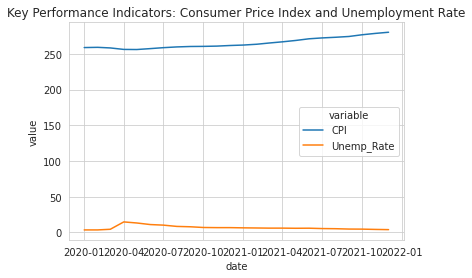

In [0]:
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

## Graph #1: Plot CPI and Unemployment over time --> on a similar scale
sns.lineplot(x="date", y="value", hue="variable", data = kpis_plotting).set(title="Key Performance Indicators: Consumer Price Index and Unemployment Rate")
#plt.savefig("data/plots/KPIs_fig1.png")

Out[48]: [Text(0.5, 1.0, 'Key Performance Indicators: DOW')]

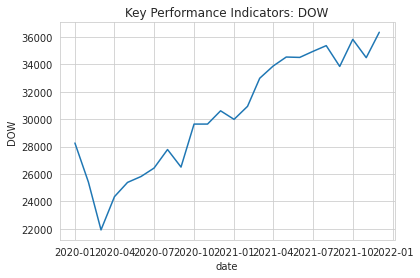

In [0]:
## Graph #1: Plot DOW over time --> on a totally separate scale
sns.lineplot(x="date", y="DOW", data = kpis).set(title="Key Performance Indicators: DOW")
#plt.savefig("data/plots/KPIs_DOW.png")

### 3) Join External Data to Reddit Data

In [0]:
#### We're joining on the 'Month' and 'Year' columns --> let's make sure they're in the same format
print(sub_all_pd[['month','year']].dtypes)
print(com_all_pd[['month','year']].dtypes)
print(kpis[['Month','Year']].dtypes)

month    int64
year     int64
dtype: object
month    int64
year     int64
dtype: object
Month    int64
Year     int64
dtype: object


In [0]:
sub_kpis = pd.merge(sub_all_pd, kpis, left_on=["year","month"], right_on=["Year","Month"])
com_kpis = pd.merge(com_all_pd, kpis, left_on=["year","month"], right_on=["Year","Month"])
print(sub_kpis)

       subreddit                                              title  score  \
0       politics  Mo Brooks Highlights Good Driving Record, Lack...      1   
1       politics  Why it 'sure looks' like Trump committed crime...   4361   
2       politics  No, antifa did not invade the Capitol today, d...      1   
3       politics  Democrat Raphael Warnock wins Senate race in G...      1   
4       politics  Reports: Trump Resisted Sending National Guard...      1   
...          ...                                                ...    ...   
42009  democrats  Obamas Release Old Photographs of Pregnant Mic...      1   
42010  democrats                             Woman at Texas Protest   2005   
42011  democrats  Republican Backers Ghostwrote A Bill Punishing...    136   
42012  democrats  Colin Powell, Politely Anguished War Criminal,...      1   
42013  democrats  Rep Adam Schiff's Interview On CBS' Face The N...      1   

       num_comments      id                time  year  month  h

In [0]:
# Drop duplicate columns
sub_kpis = sub_kpis.drop(columns=["Month", "Year"])
com_kpis = com_kpis.drop(columns=["Month","Year"])

# Check datatypes one more time to ensure they stayed correct during join
print(sub_kpis.dtypes)
print(com_kpis.dtypes)

subreddit                   object
title                       object
score                        int64
num_comments                 int64
id                          object
time                datetime64[ns]
year                         int64
month                        int64
hour                         int64
time_of_day                 object
title_length                 int64
election_year                 bool
dummy_police                  bool
dummy_healthcare              bool
dummy_climate                 bool
dummy_economy                 bool
dummy_education               bool
dummy_trump                   bool
CPI                        float64
Unemp_Rate                 float64
DOW                        float64
date                datetime64[ns]
dtype: object
author                      object
body                        object
link_id                     object
score                        int64
subreddit                   object
time                datetime64[ns]
year  

In [0]:
### Save newly joined full dataset to DBFS
sub_spark = spark.createDataFrame(sub_kpis)
sub_spark.write.parquet('/tmp/out/sub_kpis.parquet')

com_spark = spark.createDataFrame(com_kpis)
com_spark.write.parquet('/tmp/out/com_kpis.parquet')

## NLP Text Exploration

In [0]:
pip install nltk

Python interpreter will be restarted.
  Using cached nltk-3.7-py3-none-any.whl (1.5 MB)
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached regex-2022.10.31-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (769 kB)
Python interpreter will be restarted.


In [0]:
## Read in full joined datasets again
sub = spark.read.parquet('/tmp/out/sub_kpis.parquet')
print(sub)

DataFrame[subreddit: string, title: string, score: bigint, num_comments: bigint, id: string, time: timestamp, year: bigint, month: bigint, hour: bigint, time_of_day: string, title_length: bigint, election_year: boolean, dummy_police: boolean, dummy_healthcare: boolean, dummy_climate: boolean, dummy_economy: boolean, dummy_education: boolean, dummy_trump: boolean, CPI: double, Unemp_Rate: double, DOW: double, date: timestamp]


In [0]:
com = spark.read.parquet('/tmp/out/com_kpis.parquet')
print(com)

DataFrame[author: string, body: string, link_id: string, score: bigint, subreddit: string, time: timestamp, year: bigint, month: bigint, hour: bigint, time_of_day: string, comment_length: bigint, dummy_police: boolean, dummy_healthcare: boolean, dummy_climate: boolean, dummy_economy: boolean, dummy_education: boolean, dummy_trump: boolean, CPI: double, Unemp_Rate: double, DOW: double, date: timestamp]


In [0]:
# Read in necessary  packages
import re
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
from nltk.stem.snowball import SnowballStemmer
st = SnowballStemmer('english')
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
##### Examine data again
sub.printSchema()

root
 |-- subreddit: string (nullable = true)
 |-- title: string (nullable = true)
 |-- score: long (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- id: string (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- year: long (nullable = true)
 |-- month: long (nullable = true)
 |-- hour: long (nullable = true)
 |-- time_of_day: string (nullable = true)
 |-- title_length: long (nullable = true)
 |-- election_year: boolean (nullable = true)
 |-- dummy_police: boolean (nullable = true)
 |-- dummy_healthcare: boolean (nullable = true)
 |-- dummy_climate: boolean (nullable = true)
 |-- dummy_economy: boolean (nullable = true)
 |-- dummy_education: boolean (nullable = true)
 |-- dummy_trump: boolean (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Unemp_Rate: double (nullable = true)
 |-- DOW: double (nullable = true)
 |-- date: timestamp (nullable = true)



In [0]:
com.printSchema()

root
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- score: long (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- year: long (nullable = true)
 |-- month: long (nullable = true)
 |-- hour: long (nullable = true)
 |-- time_of_day: string (nullable = true)
 |-- comment_length: long (nullable = true)
 |-- dummy_police: boolean (nullable = true)
 |-- dummy_healthcare: boolean (nullable = true)
 |-- dummy_climate: boolean (nullable = true)
 |-- dummy_economy: boolean (nullable = true)
 |-- dummy_education: boolean (nullable = true)
 |-- dummy_trump: boolean (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Unemp_Rate: double (nullable = true)
 |-- DOW: double (nullable = true)
 |-- date: timestamp (nullable = true)



In [0]:
# Print size of data
print("Size of submissions dataframe", sub.count())
print("Size of comments dataframe", com.count())

Size of submissions dataframe 42014
Size of comments dataframe 440868


In [0]:
# Print number of partitions
print("Number of partitions in submissions dataframe: ", sub.rdd.getNumPartitions())
print("Number of partitions in comments dataframe: ", com.rdd.getNumPartitions())

Number of partitions in submissions dataframe:  8
Number of partitions in comments dataframe:  20


### 1) Basic data text checks/analysis

Identify most common words overall (+ over time), model distribution of text lengths

In [0]:
# Show text from submissions and comments dataframes
sub.select('title').show()

+--------------------+
|               title|
+--------------------+
|Nancy Pelosi's ho...|
|"This Whole Thing...|
|Chaos on Capitol ...|
|Right-wing extrem...|
|Here are six vide...|
|Goodbye Trump, He...|
|Don’t tease, Donn...|
|https://2021tees....|
|Democrats plans i...|
|              Savage|
|WE ALL SEE THE DI...|
|  Hit The Road Trump|
| Twitter =! Congress|
|Happy Election Ni...|
|Raphael Warnock w...|
|Secret Service Sw...|
|Facebook Blocks T...|
|Don Winslow Films...|
|I saw this meme t...|
|Insurrection- thi...|
+--------------------+
only showing top 20 rows



In [0]:
com.select('body').show()

+--------------------+
|                body|
+--------------------+
|Geez.\n\nIf they ...|
|Wow! I didn't kno...|
|We need more than...|
|The Republican pa...|
|It is their own u...|
|All they care abo...|
|He needs a covid ...|
|In the scholar su...|
|"If at first you ...|
|            Succinct|
|Great.... more fo...|
|It's gonna be Tru...|
|Your submission h...|
|I would support t...|
|Damn t-shirt spam...|
|You’re right, the...|
|It's hard to be a...|
|  What a dumb bitch.|
|This is like an e...|
|Thank God for our...|
+--------------------+
only showing top 20 rows



In [0]:
sub_small = sub.sample(0.01,123)

In [0]:
com_small = com.sample(0.01, 123)

In [0]:
sub_titles = sub.toPandas()[['subreddit','title']]
com_body = com.toPandas()[['subreddit', 'body']]

# Print submissions output
sub_titles

subreddit 
 title 
 
 
 
 
 0 
 democrats 
 Nancy Pelosi's house vandalized with a message... 
 
 
 1 
 democrats 
 "This Whole Thing Hit Me In A Very Hard, And A... 
 
 
 2 
 democrats 
 Chaos on Capitol Hill: A Sad Day for America's... 
 
 
 3 
 democrats 
 Right-wing extremists vow to return to Washing... 
 
 
 4 
 democrats 
 Here are six videos of Democrats calling for v... 
 
 
 ... 
 ... 
 ... 
 
 
 42009 
 democrats 
 Passengers tell DC Terrorist to get off the pl... 
 
 
 42010 
 democrats 
 The leader of the far-right Proud Boys was arr... 
 
 
 42011 
 democrats 
 Donald Trump Impeached For Second Time 
 
 
 42012 
 democrats 
 This lunacy made me laugh pretty hard. Party e... 
 
 
 42013 
 democrats 
 Hmm 
 
 
 
 42014 rows × 2 columns

In [0]:
# Print comments output
com_body

subreddit 
 body 
 
 
 
 
 0 
 democrats 
 Geez.\n\nIf they were a normal retailer their ... 
 
 
 1 
 democrats 
 Wow! I didn't know that about Kennedy. Geez 
 
 
 2 
 democrats 
 We need more than 2 parties in the country. No... 
 
 
 3 
 democrats 
 The Republican party is effectively killing of... 
 
 
 4 
 democrats 
 It is their own undoing as they will point it ... 
 
 
 ... 
 ... 
 ... 
 
 
 440863 
 Republican 
 I thought Cannon was facing backlash for sayin... 
 
 
 440864 
 Republican 
 Just because it is true doesn't mean we should... 
 
 
 440865 
 Republican 
 I'd like to propose free guns and healthcare. 
 
 
 440866 
 Republican 
 Biden only respects terrorists that kill Ameri... 
 
 
 440867 
 Republican 
 This people are mental cases 
 
 
 
 440868 rows × 2 columns

In [0]:
# Initial text cleaning (basic space removal and punctuation removal)

### Define function data_clean(text) to automate this 
def data_clean(text):
    # change to lower and remove spaces on either side
    cleaned_text = text.apply(lambda x: x.lower().strip())

    # remove extra spaces in between
    cleaned_text = cleaned_text.apply(lambda x: re.sub(' +', ' ', x))

    # remove punctuation
    cleaned_text = cleaned_text.apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

    # remove stopwords and get the stem
    cleaned_text = cleaned_text.apply(lambda x: ' '.join(st.stem(text) for text in x.split() if text not in stop_words))

    return cleaned_text
    

# Clean titles and comments
sub_titles['title'] = data_clean(sub_titles['title'])
com_body['body'] = data_clean(com_body['body'])

#### Plot word counts and identify most common words

In [0]:
# For submissions
sub_word_cnt = pd.DataFrame(sub_titles[['title']].apply(lambda x: x.str.split(expand=True).stack()).stack().value_counts())
sub_word_cnt = sub_word_cnt.reset_index()
sub_word_cnt.columns = ['word','count']
top_words = sub_word_cnt[:50]

Out[16]: <BarContainer object of 50 artists>

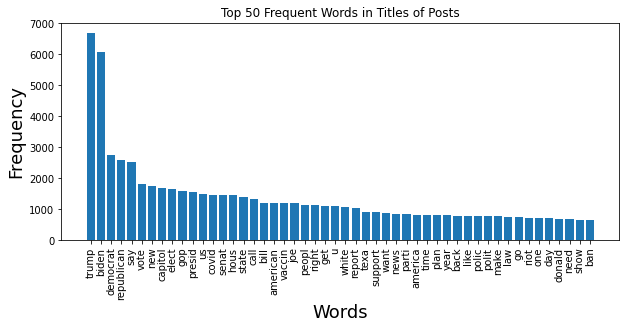

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.xticks(rotation=90)
FS = 18
plt.xlabel('Words', fontsize=FS)
plt.ylabel('Frequency', fontsize=FS)
plt.title("Top 50 Frequent Words in Titles of Posts")
plt.bar(top_words['word'], top_words['count'])
plt.savefig('data/plots/top_50_words.png')# Save to data/plots folder

###### Wordclouds of top words for 1) titles and 2) comments

In [0]:
!pip install wordcloud

     |████████████████████████████████| 458 kB 11.5 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-8ba3db58-a005-4bdc-964c-aad7e0a1f8a6/bin/python -m pip install --upgrade pip' command.


In [0]:
### Define function to automate wordcloud generation
def generate_word_cloud(my_text, title):
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud, STOPWORDS
    # Define a function to plot word cloud
    def plot_cloud(wordcloud):
        # Set figure size
        plt.figure(figsize=(10, 10))
        # Display image
        plt.imshow(wordcloud) 
        # No axis details
        plt.axis("off");

    # Generate word cloud
    wordcloud = WordCloud(
        width = 1500,
        height = 1000, 
        random_state=1, 
        #background_color='salmon', 
        colormap='Pastel1', 
        collocations=False,
        stopwords = STOPWORDS).generate(my_text)
    plot_cloud(wordcloud)
    plt.show()
    plt.savefig('data/plots/'+title+'.png')

In [0]:
# Submissions titles
politics_titles = sub_titles[sub_titles['subreddit'] == 'politics']
politics_text = ' '.join(i for i in politics_titles['title'])

republican_titles = sub_titles[sub_titles['subreddit'] == 'Republican']
republican_text = ' '.join(i for i in republican_titles['title'])

democrats_titles = sub_titles[sub_titles['subreddit'] == 'democrats']
democrats_text = ' '.join(i for i in democrats_titles['title'])

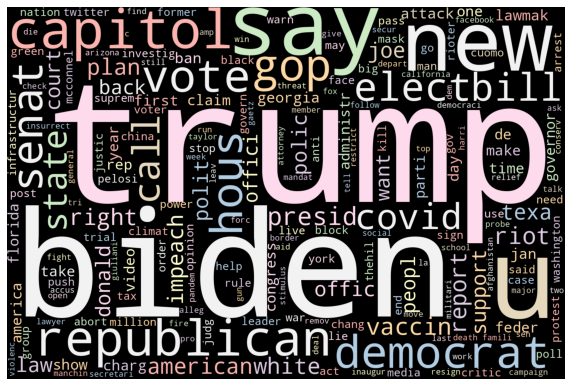

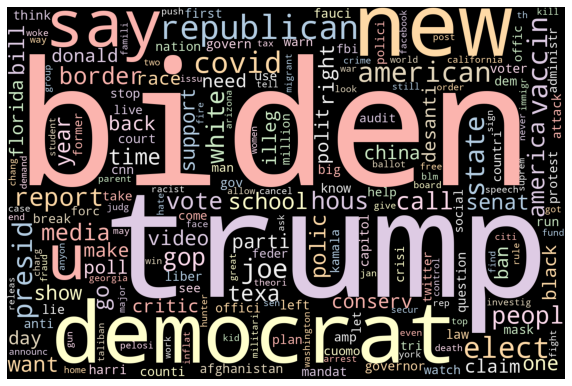

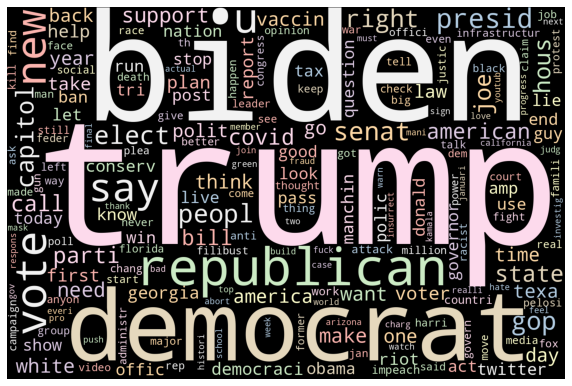

In [0]:
### Submissions titles wordclouds
generate_word_cloud(politics_text, "politics_titles_wordcloud")
generate_word_cloud(republican_text, "republican_titles_wordcloud")
generate_word_cloud(democrats_text, "democrats_titles_wordcloud")

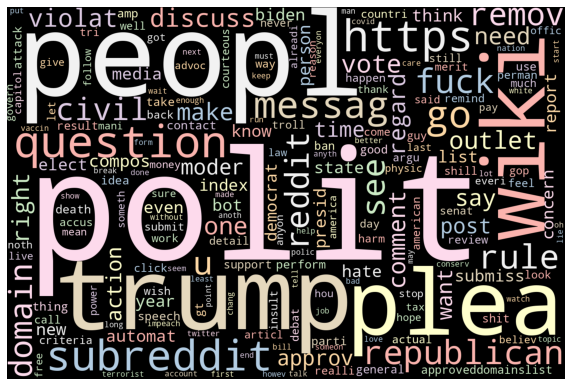

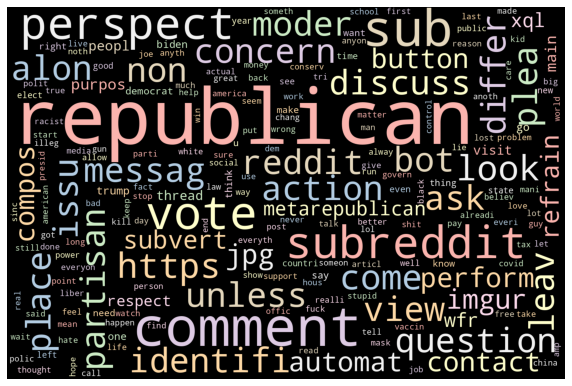

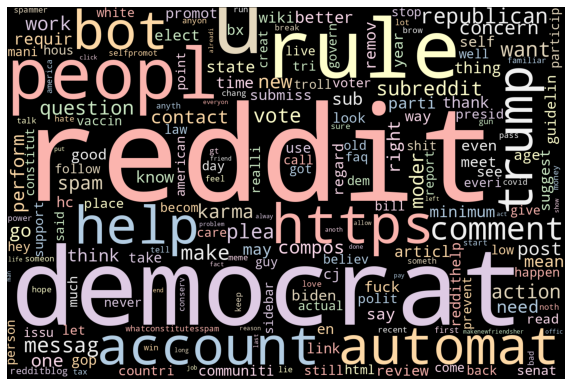

In [0]:
# Comments
politics_titles = com_body[com_body['subreddit'] == 'politics']
politics_text = ' '.join(i for i in politics_titles['body'])

republican_titles = com_body[com_body['subreddit'] == 'Republican']
republican_text = ' '.join(i for i in republican_titles['body'])

democrats_titles = com_body[com_body['subreddit'] == 'democrats']
democrats_text = ' '.join(i for i in democrats_titles['body'])

### Comments titles wordclouds
generate_word_cloud(politics_text, "politics_comments_wordcloud")
generate_word_cloud(republican_text, "republican_comments_wordcloud")
generate_word_cloud(democrats_text, "democrats_comments_wordcloud")

### 2) Build bag of words dictionary

In [0]:
### For the titles
sub_titles

subreddit 
 title 
 
 
 
 
 0 
 democrats 
 nanci pelosi hous vandal messag allud stimulus... 
 
 
 1 
 democrats 
 whole thing hit hard real way uncov truth w br... 
 
 
 2 
 democrats 
 chao capitol hill sad day america democraci bp... 
 
 
 3 
 democrats 
 right wing extremist vow return washington joe... 
 
 
 4 
 democrats 
 six video democrat call violenc physic confron... 
 
 
 ... 
 ... 
 ... 
 
 
 42009 
 democrats 
 passeng tell dc terrorist get plane usernamech... 
 
 
 42010 
 democrats 
 leader far right proud boy arrest washington 
 
 
 42011 
 democrats 
 donald trump impeach second time 
 
 
 42012 
 democrats 
 lunaci made laugh pretti hard parti echo chamb... 
 
 
 42013 
 democrats 
 hmm 
 
 
 
 42014 rows × 2 columns

In [0]:
bow_sub_dict= (sub_titles[['title']].apply(lambda x: x.str.split(expand=True).stack()).stack().value_counts()).to_dict()
bow_sub_dict

Out[23]: {'trump': 6689,
 'biden': 6089,
 'democrat': 2749,
 'republican': 2602,
 'say': 2527,
 'vote': 1803,
 'new': 1766,
 'capitol': 1673,
 'elect': 1646,
 'gop': 1573,
 'presid': 1547,
 'us': 1483,
 'covid': 1465,
 'senat': 1464,
 'hous': 1456,
 'state': 1398,
 'call': 1324,
 'bill': 1216,
 'american': 1215,
 'vaccin': 1211,
 'joe': 1189,
 'peopl': 1147,
 'right': 1145,
 'get': 1102,
 'u': 1101,
 'white': 1068,
 'report': 1038,
 'texa': 908,
 'support': 898,
 'want': 863,
 'news': 857,
 'parti': 840,
 'america': 828,
 'time': 825,
 'plan': 819,
 'year': 804,
 'back': 790,
 'like': 784,
 'polic': 778,
 'polit': 775,
 'make': 770,
 'law': 737,
 'go': 736,
 'riot': 732,
 'one': 731,
 'day': 713,
 'donald': 686,
 'need': 676,
 'show': 653,
 'ban': 652,
 'would': 649,
 'take': 647,
 'first': 646,
 'court': 645,
 'offic': 629,
 'impeach': 616,
 'video': 614,
 'could': 596,
 'media': 596,
 'governor': 590,
 'georgia': 588,
 'voter': 587,
 'claim': 575,
 'offici': 573,
 'attack': 567,
 'fl

In [0]:
# Export bag of words
import json
json.dump({'bag_of_words' : bow_sub_dict}, 
          fp = open('data/csv/bag_of_words.json','w'))

### 3) Identify the most important words (TFIDF vectorized)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TFIDF Vectorize text and titles
tfidf_vec = TfidfVectorizer() # Initialize TFIDFVectorizer

sub_tfidf = tfidf_vec.fit_transform(sub_titles['title'])
SubColumnNames = tfidf_vec.get_feature_names()

com_tfidf = tfidf_vec.fit_transform(com_body['body'])
ComColumnNames = tfidf_vec.get_feature_names()

In [0]:
# View output and extract most important words
sub_tfidf = pd.DataFrame(sub_tfidf.toarray(),columns=SubColumnNames) # Convert to array, then dataframe
#com_tfidf = pd.DataFrame(com_tfidf.toarray()) # Convert to array, then dataframe

In [0]:
## Sum each column (summing frequency)
imp_words_sorted = sub_tfidf.sum(axis=0).sort_values(ascending=False)
top_words = imp_words_sorted.head(50)
print(top_words)

trump         1069.149725
biden          985.203592
democrat       582.692295
republican     564.095862
say            491.128562
vote           405.417396
new            373.522438
capitol        366.583698
elect          364.859907
presid         362.108193
gop            349.920136
senat          331.942788
covid          326.977433
hous           324.454452
us             323.505051
joe            316.593372
state          300.386945
vaccin         292.193994
call           287.093732
american       285.476482
right          283.265621
bill           283.146102
peopl          261.448234
get            259.456712
white          244.958078
report         234.819649
support        232.622477
america        227.084014
parti          226.405550
texa           222.598233
want           214.678559
time           212.117866
plan           209.403450
news           207.186433
polit          206.160748
like           202.465067
back           202.253247
donald         197.264620
go          

### 4) Plot distribution of text lengths

In [0]:
from pyspark.sql.functions import length

In [0]:
sub_lengths = sub.withColumn('title_length', length("title"))
sub_lengths = sub_lengths.select('title', 'title_length', 'month', 'year')
sub_lengths.show()

+--------------------+------------+-----+----+
|               title|title_length|month|year|
+--------------------+------------+-----+----+
|Nancy Pelosi's ho...|         132|    1|2021|
|"This Whole Thing...|          99|    1|2021|
|Chaos on Capitol ...|          73|    1|2021|
|Right-wing extrem...|         271|    1|2021|
|Here are six vide...|         113|    1|2021|
|Goodbye Trump, He...|          36|    1|2021|
|Don’t tease, Donn...|          65|    1|2021|
|https://2021tees....|          46|    1|2021|
|Democrats plans i...|          80|    1|2021|
|              Savage|           6|    1|2021|
|WE ALL SEE THE DI...|          27|    1|2021|
|  Hit The Road Trump|          18|    1|2021|
| Twitter =! Congress|          19|    1|2021|
|Happy Election Ni...|          24|    1|2021|
|Raphael Warnock w...|         101|    1|2021|
|Secret Service Sw...|          80|    1|2021|
|Facebook Blocks T...|          72|    1|2021|
|Don Winslow Films...|          38|    1|2021|
|I saw this m

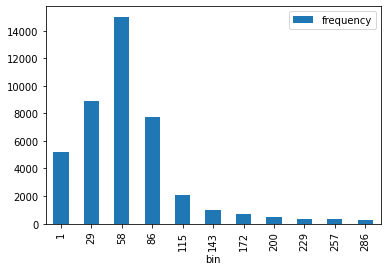

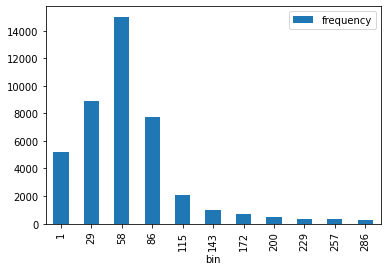

In [0]:
### Plot distribution of title lengths (https://stackoverflow.com/questions/39154325/pyspark-show-histogram-of-a-data-frame-column)

sub_length_hist = sub_lengths.select('title_length').rdd.flatMap(lambda x: x).histogram(11)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
hist_df = pd.DataFrame(
    list(zip(*sub_length_hist)), 
    columns=['bin', 'frequency'])
hist_df["bin"] = np.floor(hist_df.bin).astype(int)
hist_df.set_index('bin').plot(kind='bar').get_figure().savefig('data/plots/titles_length_dist.png')

In [0]:
com_lengths = com.withColumn('comment_length', length("body"))
com_lengths = com_lengths.select('body', 'comment_length', 'month', 'year')
com_lengths.show()

+--------------------+--------------+-----+----+
|                body|comment_length|month|year|
+--------------------+--------------+-----+----+
|Geez.\n\nIf they ...|           108|    4|2021|
|Wow! I didn't kno...|            43|    4|2021|
|We need more than...|           428|    4|2021|
|The Republican pa...|          1847|    4|2021|
|It is their own u...|            82|    4|2021|
|All they care abo...|            67|    4|2021|
|He needs a covid ...|            29|    4|2021|
|In the scholar su...|           188|    4|2021|
|"If at first you ...|            45|    4|2021|
|            Succinct|             8|    4|2021|
|Great.... more fo...|           123|    4|2021|
|It's gonna be Tru...|           149|    4|2021|
|Your submission h...|           805|    4|2021|
|I would support t...|           148|    4|2021|
|Damn t-shirt spam...|            21|    4|2021|
|You’re right, the...|            78|    4|2021|
|It's hard to be a...|           120|    4|2021|
|  What a dumb bitch

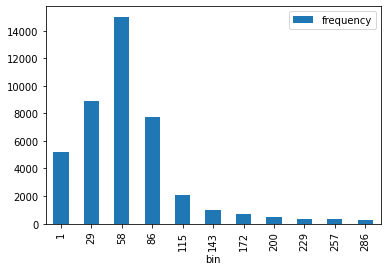

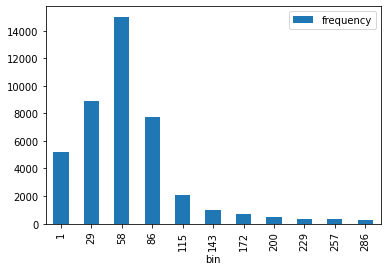

In [0]:
### Plot distribution of comment lengths (https://stackoverflow.com/questions/39154325/pyspark-show-histogram-of-a-data-frame-column)

com_length_hist = com_lengths.select('comment_length').rdd.flatMap(lambda x: x).histogram(11)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
hist_df = pd.DataFrame(
    list(zip(*sub_length_hist)), 
    columns=['bin', 'frequency'])
hist_df["bin"] = np.floor(hist_df.bin).astype(int)
hist_df.set_index('bin').plot(kind='bar').get_figure().savefig('data/plots/comments_length_dist.png')

## NLP Text Cleaning

### 1) Clean data → stemming, punctuation, stopwords, etc. (5 procedures)

In [0]:
## Load in required packages
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql.functions import *

In [0]:
title_df = sub.select('title')
comments_df = com.select('body')

In [0]:
## 1) Stem words
stemmer = Stemmer() \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("stem")

## 2) Remove stopwords
stopwords_cleaner = StopWordsCleaner()\
    .setInputCols("token")\
    .setOutputCol("cleanTokens")\
    .setCaseSensitive(False)\
    #.setStopWords(["no", "without"]) (e.g. read a list of words from a txt)

# 3) Lowercase all words
# 4) Remove non-alphanumeric characters
normalizer = Normalizer() \
    .setInputCols(["stem"]) \
    .setOutputCol("normalized")\
    .setLowercase(True)\
    .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])
    
documentAssembler = DocumentAssembler()\
    .setInputCol("title")\
    .setOutputCol("document")

# 5) Tokenize
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

tokenassembler = TokenAssembler()\
    .setInputCols(["document", "normalized"]) \
    .setOutputCol("clean_text")

nlpPipeline = Pipeline(stages=[documentAssembler, 
                               tokenizer,
                               stopwords_cleaner,
                               stemmer,
                              normalizer,
                              tokenassembler])

In [0]:
## Submissions first
sub_result = nlpPipeline.fit(title_df).transform(title_df)

sub_result = sub_result.select('clean_text.result', explode(sub_result.clean_text.result).alias('clean_text'))
sub_result = sub_result.select('clean_text')
sub_result.show()

+--------------------+
|          clean_text|
+--------------------+
|nanci pelosi hous...|
|whole thing hit h...|
|chao capitol hill...|
|rightw extremist ...|
|six video democra...|
|goodby trump hell...|
|dont teas donni l...|
|https2021teesmysh...|
|democrat plan imp...|
|               savag|
|         see diffeer|
|      hit road trump|
|    twitter congress|
| happi elect night d|
|raphael warnock w...|
|secret servic swi...|
|facebook block tr...|
|winslow film josh...|
|saw meme templat ...|
|insurrect peac pr...|
+--------------------+
only showing top 20 rows



In [0]:
## Comments
## Rename 'body' to 'title' so it works with our NLP Pipeline
comments_df = comments_df.withColumnRenamed("body", "title")

com_result = nlpPipeline.fit(comments_df).transform(comments_df)

com_result = com_result.select('clean_text.result', explode(com_result.clean_text.result).alias('clean_text'))
com_result = com_result.select('clean_text')
com_result.show()

+--------------------+
|          clean_text|
+--------------------+
|geez normal retai...|
|wow know kennedi ...|
|ne 2 parti countr...|
|republican parti ...|
|undo point parti ...|
|care muh gun iron...|
|ne covid variant ...|
|scholar survei ta...|
|  first succ try try|
|            succinct|
|great blue state ...|
|gonna trump 2024 ...|
|submiss automat r...|
|support think lea...|
| damn tshirt spammer|
|your right conseq...|
|hard centrist par...|
|          dumb bitch|
|like episod black...|
|thank god governo...|
+--------------------+
only showing top 20 rows



## Save data to DBFS to be used for models

Separate notebooks for models

In [0]:
### Save newly joined full dataset to DBFS
sub_result.write.parquet('/tmp/out/sub_result.parquet')

com_result.write.parquet('/tmp/out/com_result.parquet')

### Close Spark Session

In [0]:
spark.stop()